# Visualize Graph Data Model Using Diagram-as-Code: Property Graph

This notebook shows how to introspect data in your Neptune database and draw a diagram representing the contents of that model. It uses a diagram-as-code approach.

Min Requirement: Neptune 1.2.x

There will be another one for RDF

## Setup PlantUML

In [ ]:
%pip install iplantuml

### Restart the kernel
To use the libraries installed above, restart the notebook kernel. In Jupyter, choose menu Kernel | Restart and Clear Output.

In [ ]:
import iplantuml

## Load some data if you like
If not, skip and we'll go with what you've got

In [ ]:
%seed --model property_graph --dataset fraud_graph

## Get schema from Neptune DB
Start with summary API
Dig a bit deeper with some queries

Here's a reference: https://github.com/aws/amazon-neptune-for-graphql/blob/main/src/NeptuneSchema.js

In [ ]:
pip install igraph -q 

In [ ]:
pip install jsonpath-ng

In [ ]:
import awswrangler as wr
import pandas as pd
import igraph as ig
import graph_notebook as gn
from graph_notebook.configuration.generate_config import AuthModeEnum

# Get the configuration information for the notebook
config = gn.configuration.get_config.get_config()
iam=True if config.auth_mode==AuthModeEnum.IAM else False

# Retrieve Data from neptune
client = wr.neptune.connect(config.host, config.port, iam_enabled=iam)

def run_oc_introspect(query):
    df = wr.neptune.execute_opencypher(client, query)
    #display(df.head(10))
    return df


In [ ]:
%summary --detail --store-to pgsummary propertygraph

In [ ]:
classes={}
rel_classes={}

RESULT_LIMIT=10000

'''
TODO - see if string is actually a date-time
DateTime   –   A Java date in one of the following ISO-8601 formats:

    yyyy-MM-dd

    yyyy-MM-ddTHH:mm

    yyyy-MM-ddTHH:mm:ss

    yyyy-MM-ddTHH:mm:ssZ
'''
def map_type(typ):
    if str(typ) == "<class 'int'>":
        return "int"
    if str(typ) == "<class 'float'>":
        return "float"
    if str(typ) == "<class 'bool'>":
        return "boolean"
    if str(typ) == "<class 'str'>":
        return "string"
    return "string"

def determine_type(prop, val):
    typ = type(val)
    if typ is list:
        prop['multival'] = True
        for v in list(val):
            mtyp = map_type(type(v))
            if not(mtyp in prop['types']):
                prop['types'].append(mtyp)
    else:
        mtyp = map_type(typ)
        if not (mtyp in prop['types']):
            prop['types'].append(mtyp)

    
for n in pgsummary['payload']['graphSummary']['nodeLabels']:
    print(n)
    classes[n] = {'labels': [], 'props': {}, 'rels': {}}
    
    # node labels
    structure_query = f"MATCH(n:{n}) RETURN distinct labels(n) as labels ORDER BY rand() LIMIT {RESULT_LIMIT}"    
    df = run_oc_introspect(structure_query)
    for index, row in df.iterrows():
        labels = row['labels']
        classes[n]['labels'].append(labels)
    
    # node props
    structure_query = f"MATCH(n:{n}) RETURN properties(n) as props ORDER BY rand() LIMIT {RESULT_LIMIT}"    
    df = run_oc_introspect(structure_query)
    for index, row in df.iterrows():
        props = row['props']
        for p in props:
            if not(p in classes[n]['props']):
                classes[n]['props'][p] = {'multival': False, 'types': []}
            determine_type(classes[n]['props'][p], props[p])

    # edges
    structure_query = f"MATCH(n:{n})-[e]->(m) RETURN distinct type(e) as edgetype, labels(m) as target ORDER BY rand() LIMIT {RESULT_LIMIT}"    
    df = run_oc_introspect(structure_query)
    for index, row in df.iterrows():
        edge_type = row['edgetype']
        target = row['target']
        if not(edge_type in classes[n]['rels']):
            classes[n]['rels'][edge_type] = target

    # edge properties when that node is source
    structure_query = f"MATCH(n:{n})-[e]->(m) RETURN type(e) as edgetype, properties(e) as props ORDER BY rand() LIMIT {RESULT_LIMIT}"    
    df = run_oc_introspect(structure_query)
    for index, row in df.iterrows():
        edge_type = row['edgetype']
        props = row['props']
        if len(props) > 0:
            rel_class = {'props': {}}
            if edge_type in rel_classes:
                rel_class = rel_classes[edge_type]
            else:
                rel_classes[edge_type] = rel_class
            for p in props:
                if not(p in rel_classes[edge_type]['props']):
                    rel_classes[edge_type]['props'][p] = {'multival': False, 'types': []}
                determine_type(rel_classes[edge_type]['props'][p], props[p])

[classes, rel_classes]

In [ ]:
# Gap analysis - anything from summary not in our model

# node labels
for n in pgsummary['payload']['graphSummary']['nodeLabels']:
    if not(n in classes):
        print(f"***** Summary node label not accounted for {n}")

# edge labels
for e in pgsummary['payload']['graphSummary']['edgeLabels']:
    found = True
    for n in classes:
        if e in classes[n]['rels']:
            found = True
            break
            
    if not(found):
        print(f"***** Summary edge label not accounted for {e}")

# node properties
for np in pgsummary['payload']['graphSummary']['nodeProperties']:
    found = True
    for p in np:
        for n in classes:
            if p in classes[n]['props']:
                found = True
                break            
        if not(found):
            print(f"***** Node property not accounted for {p}")

# edge properties
for ep in pgsummary['payload']['graphSummary']['edgeProperties']:
    found = True
    for p in ep:
        for n in rel_classes:
            if p in rel_classes[n]['props']:
                found = True
                break            
        if not(found):
            print(f"***** Edge property not accounted for {p}")

# node structures
for ns in pgsummary['payload']['graphSummary']['nodeStructures']:
    len_props = len(ns['nodeProperties'])
    len_rels = len(ns['distinctOutgoingEdgeLabels'])
    found = False
    for n in classes:
        props_found = False
        rels_found = False
        ccount = 0
        for p in ns['nodeProperties']:
            if p in classes[n]['props']:
                ccount += 1
        if ccount == len_props:
            props_found = True
                
        if len_rels == 0:
            rels_found = True
        else:
            rcount = 0
            for p in ns['distinctOutgoingEdgeLabels']:
                if p in classes[n]['rels']:
                    rcount += 1
            if rcount == len_rels:
                rels_found = True
                
        if props_found and rels_found:
            found = True
            break
    if not(found):
        print(f"***** Node structure not accounted for  {ns}")

# edge structures
for es in pgsummary['payload']['graphSummary']['edgeStructures']:
    found = False
    len_props = len(es['edgeProperties'])
    for r in rel_classes:
        rcount = 0
        for p in es['edgeProperties']:
            if p in rel_classes[r]['props']:
                rcount += 1
        if rcount == len_props:
            #print("edge prop match " + r)
            found = True
            break
    if not(found):
        print(f"***** Edge structure not accounted for {es}")

print("Checks done")

## Visualize
### Build PlantUML spec

In [ ]:
classes_str = ""
rels_str = ""

def print_type(t):
    s = t['types'][0]
    if t['multival']:
        s += "*"
    if len(t['types']) > 1:
        s += f(" also t['types'][1:]")
    return s

for c in classes:
    classstr = f"\nclass {c} {{"
    for p in classes[c]['props']:
        classstr += f"\n   - {p}:{print_type(classes[c]['props'][p])}"

    for r in classes[c]['rels']:
        for target in classes[c]['rels'][r]:
            rels_str += f'\n{c} "1" -- "*" {target} : {r} > '
            
        if r in rel_classes:
            propstr = ""
            for rp in rel_classes[r]['props']:
                propstr += f"{rp}:{print_type(rel_classes[r]['props'][rp])} "
            rels_str += f"\nnote on link : {propstr}"


    classstr += "\n}"
    classes_str += classstr

plantspec = f"""
@startuml

{classes_str}

{rels_str}

@enduml
"""

In [ ]:
print(plantspec)

### Render from the Spec

In [ ]:
ipython = get_ipython()
ipython.run_cell_magic("plantuml", "", plantspec)

### If I want to tweak it, do here and render
Here's what I got for air route
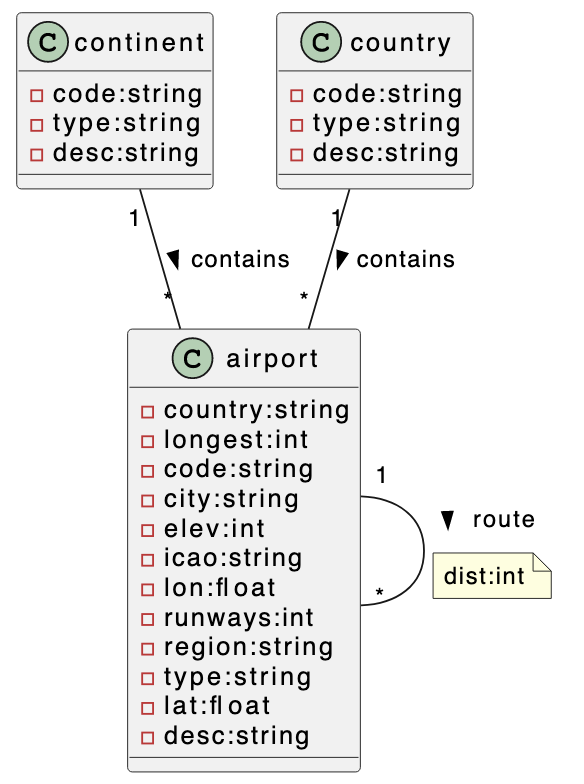

In [ ]:
%%plantuml


@startuml


class continent {
   - code:string
   - type:string
   - desc:string
}
class country {
   - code:string
   - type:string
   - desc:string
}

class airport {
   - country:string
   - longest:int
   - code:string
   - city:string
   - elev:int
   - icao:string
   - lon:float
   - runways:int
   - region:string
   - type:string
   - lat:float
   - desc:string
}

continent "1" -- "*" airport : contains > 
country "1" -- "*" airport : contains > 
airport "1" -- "*" airport : route > 
note on link : dist:int 

@enduml

Here's fraud graph

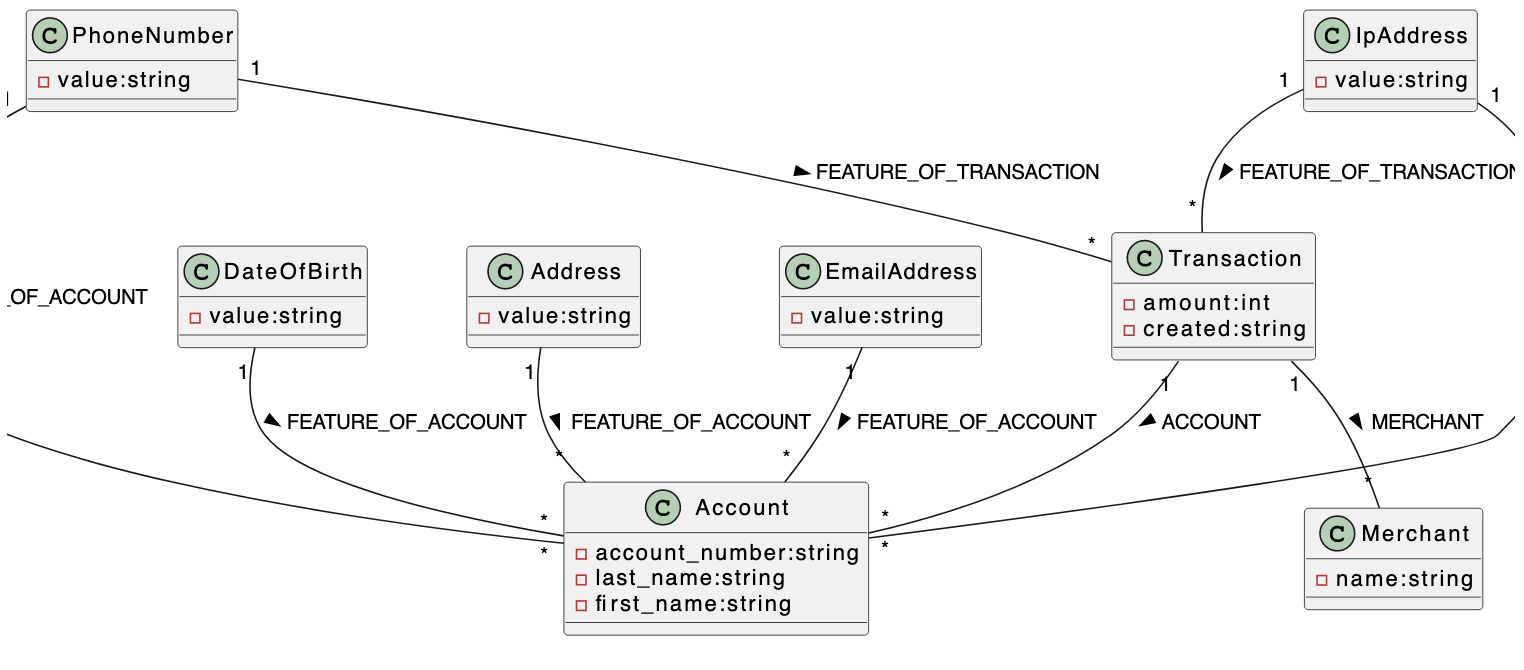

In [ ]:
%%plantuml


@startuml


class DateOfBirth {
   - value:string
}

class Account {
   - account_number:string
   - last_name:string
   - first_name:string
}
class Address {
   - value:string
}
class EmailAddress {
   - value:string
}

class Merchant {
   - name:string
}
class Transaction {
   - amount:int
   - created:string
}
class PhoneNumber {
   - value:string
}
class IpAddress {
   - value:string
}

DateOfBirth "1" -- "*" Account : FEATURE_OF_ACCOUNT > 
Address "1" -- "*" Account : FEATURE_OF_ACCOUNT > 
EmailAddress "1" -- "*" Account : FEATURE_OF_ACCOUNT > 
Transaction "1" -- "*" Account : ACCOUNT > 
Transaction "1" -- "*" Merchant : MERCHANT > 
PhoneNumber "1" -- "*" Transaction : FEATURE_OF_TRANSACTION > 
PhoneNumber "1" -- "*" Account : FEATURE_OF_ACCOUNT > 
IpAddress "1" -- "*" Transaction : FEATURE_OF_TRANSACTION > 
IpAddress "1" -- "*" Account : FEATURE_OF_ACCOUNT > 

@enduml
